In [1]:
# http://scikit-learn.org
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

# https://matplotlib.org
from matplotlib import pyplot as plt

# https://seaborn.pydata.org
import seaborn as sns

# http://www.numpy.org/
import numpy as np

# https://docs.python.org/2/library/csv.html
import csv

# https://docs.scipy.org
from scipy import stats

# https://keras.io/
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import callbacks
from keras.utils import plot_model

# https://docs.python.org/3/library/itertools.html
import itertools

Using TensorFlow backend.


# Process and Analyse Data

In [2]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
# load data from the csv
with open('creditcard.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    # get the name of the features in the first row
    features = next(reader)
    # get values as float
    data = [[float(value) for value in row] for row in reader]

In [3]:
# split data into x (input) and y (target)
# x is every column except the last one (target)
x = [x[:-1] for x in data]
# remove the name "class" from the features
features = features[:-1]
# y is the last column
y = [int(x[-1]) for x in data]

In [4]:
# convert x and y to numpy array
x = np.asarray(x)
y = np.asarray(y)

In [5]:
# number of example and feature
print("Number of (example, feature): {}".format(x.shape))
# number of example from class 1
ones = np.sum(y == 1)
print("Number of example from class 1: {} ({:.2%})".format(
    ones, ones / len(data)))

Number of (example, feature): (284807, 30)
Number of example from class 1: 492 (0.17%)


In [6]:
# print the features name with the values of the first example
print("{:10s}: {:^10s}".format("feature", "value"))
for f, v in zip(features, x[0]):
    print("{:10s}: {:^10f}".format(f, v))

feature   :   value   
Time      :  0.000000 
V1        : -1.359807 
V2        : -0.072781 
V3        :  2.536347 
V4        :  1.378155 
V5        : -0.338321 
V6        :  0.462388 
V7        :  0.239599 
V8        :  0.098698 
V9        :  0.363787 
V10       :  0.090794 
V11       : -0.551600 
V12       : -0.617801 
V13       : -0.991390 
V14       : -0.311169 
V15       :  1.468177 
V16       : -0.470401 
V17       :  0.207971 
V18       :  0.025791 
V19       :  0.403993 
V20       :  0.251412 
V21       : -0.018307 
V22       :  0.277838 
V23       : -0.110474 
V24       :  0.066928 
V25       :  0.128539 
V26       : -0.189115 
V27       :  0.133558 
V28       : -0.021053 
Amount    : 149.620000


In [7]:
# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [8]:
# test normality of the data
_, p = stats.normaltest(x)
print("{:10s} : {:^15s}".format("feature", "p_value"))
for feature, p_value in zip(features, p):
    print("{:10s} : {:^15g}".format(feature, p_value))

feature    :     p_value    
Time       :        0       
V1         :        0       
V2         :        0       
V3         :        0       
V4         :        0       
V5         :        0       
V6         :        0       
V7         :        0       
V8         :        0       
V9         :        0       
V10        :        0       
V11        :        0       
V12        :        0       
V13        :  2.41997e-126  
V14        :        0       
V15        :        0       
V16        :        0       
V17        :        0       
V18        :        0       
V19        :        0       
V20        :        0       
V21        :        0       
V22        :        0       
V23        :        0       
V24        :        0       
V25        :        0       
V26        :        0       
V27        :        0       
V28        :        0       
Amount     :        0       


In [9]:
# randomly split the data into a train set, a validation set and a test set
# we cannot use CV as it takes too long to train a network.
# stratify allows to the keep the classes\' distribution in each subset
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=230000, test_size=50000, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=50000, stratify=y_train)
# print shapes
print("Train: {}".format(x_train.shape))
print("Validation: {}".format(x_valid.shape))                
print("Test: {}".format(x_test.shape))         
# the implementation of the VAE needs to have mini-batches of equal size
# each data set needs to be divisible by the batch size (100)

Train: (180000, 30)
Validation: (50000, 30)
Test: (50000, 30)


Populating the interactive namespace from numpy and matplotlib


/home/recherche/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'ones']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


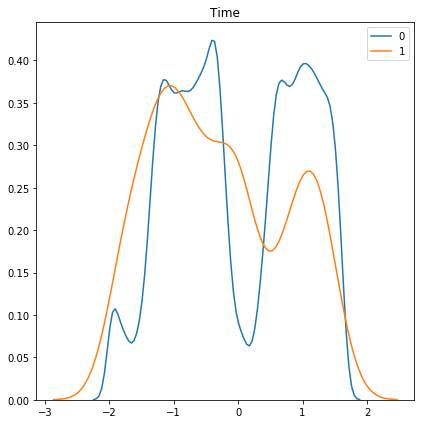

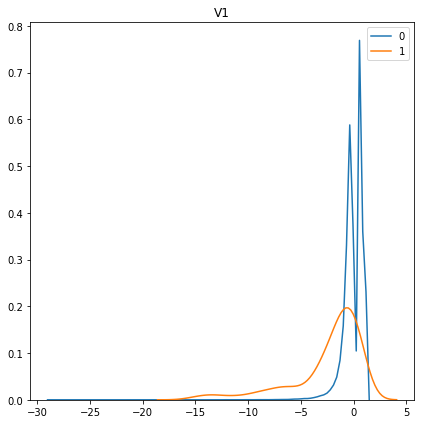

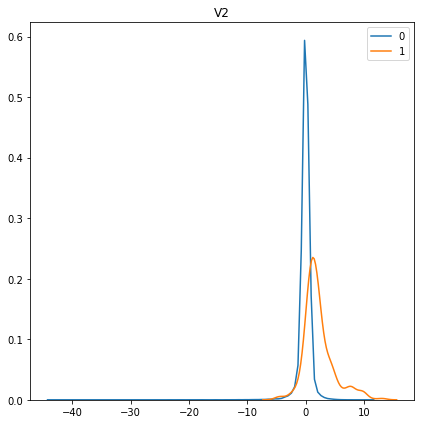

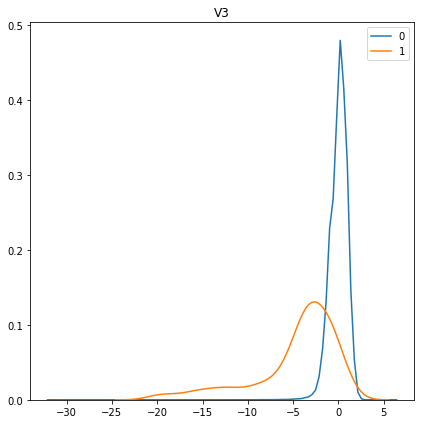

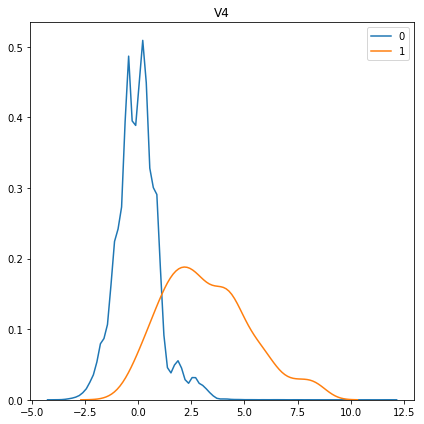

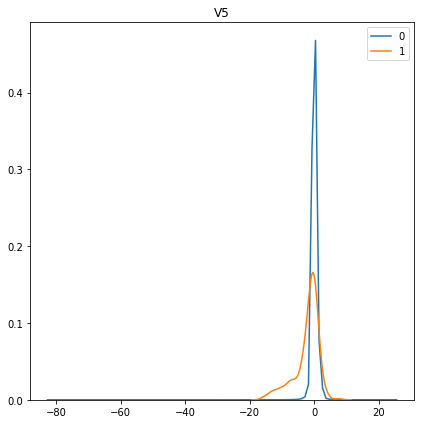

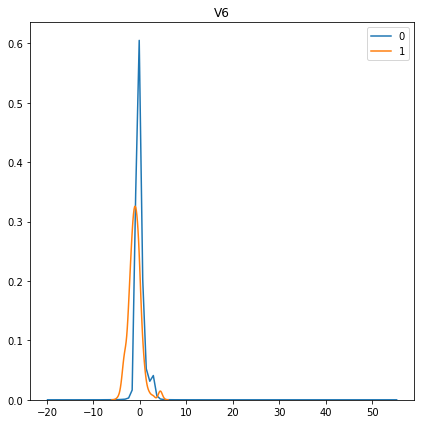

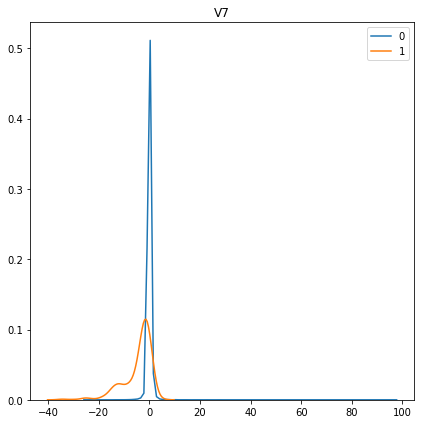

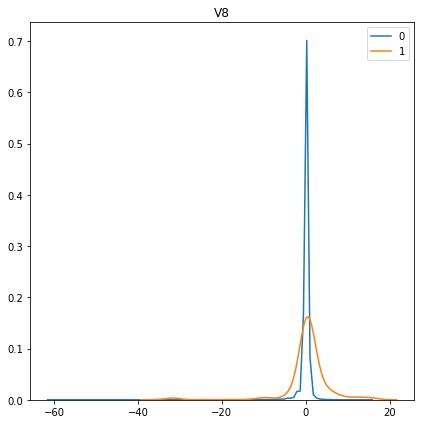

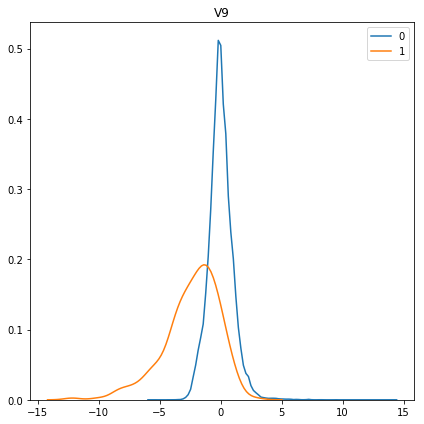

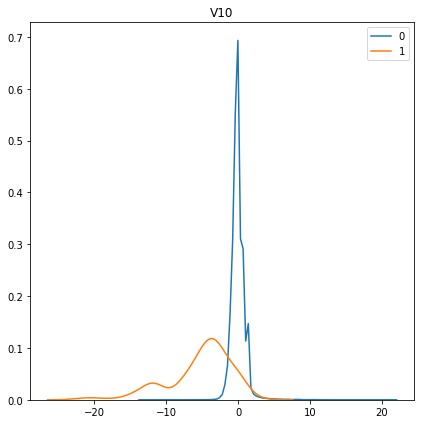

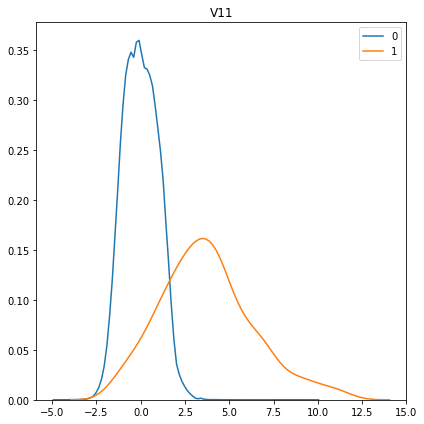

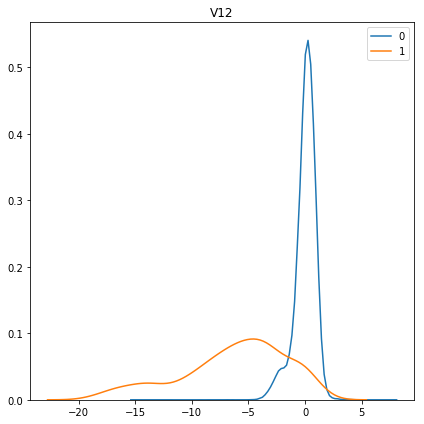

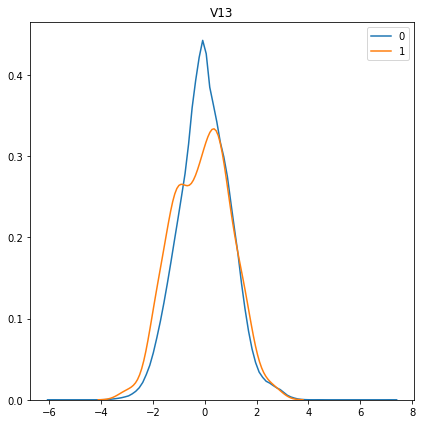

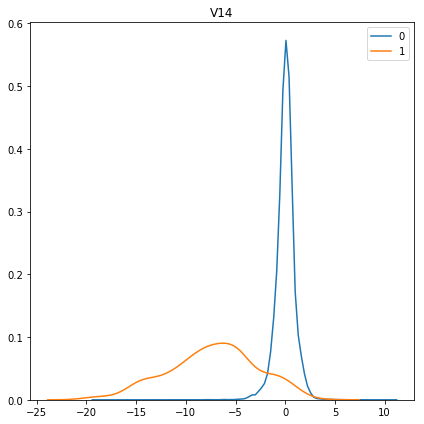

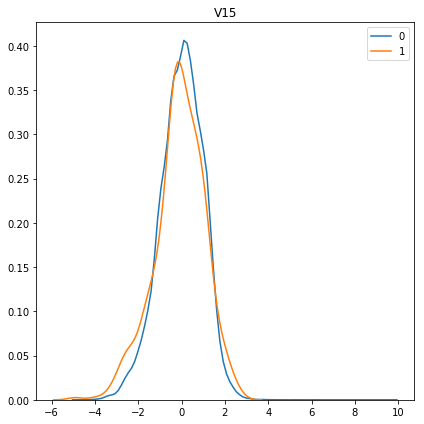

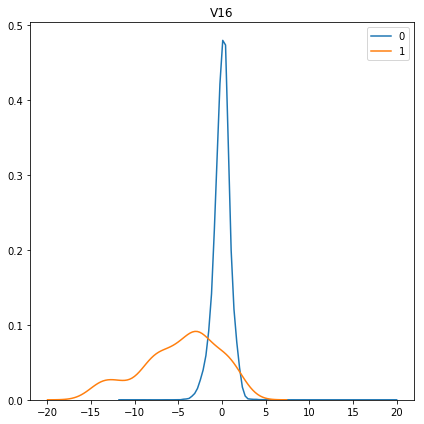

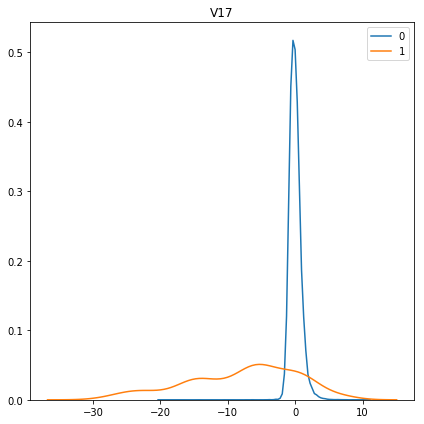

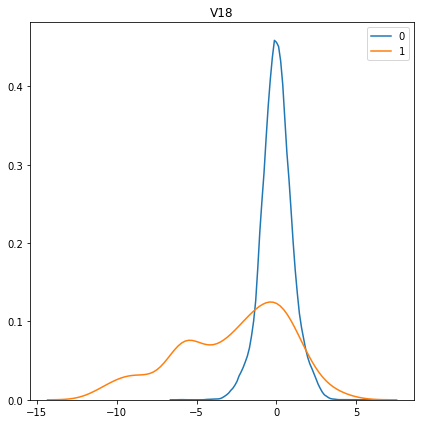

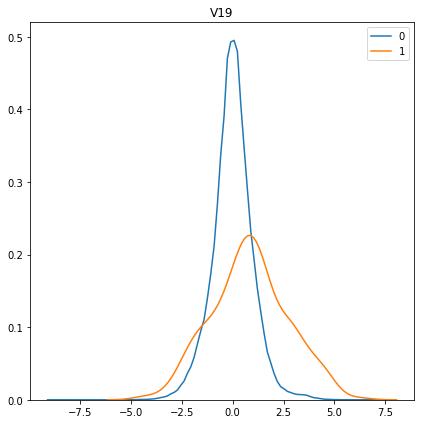

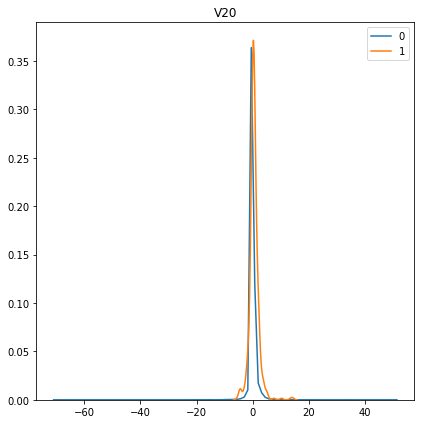

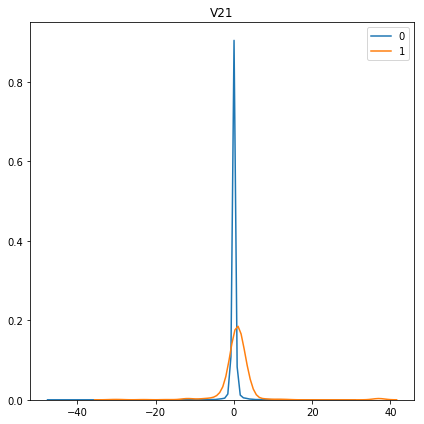

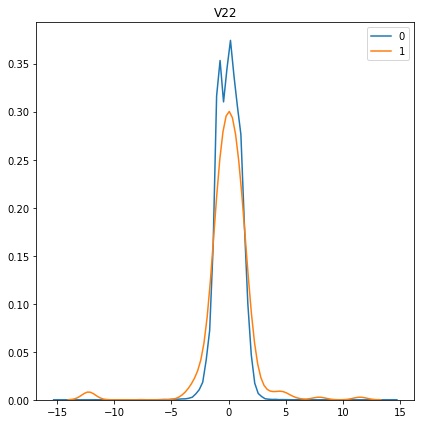

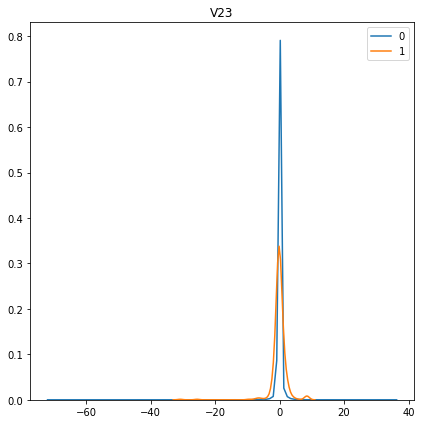

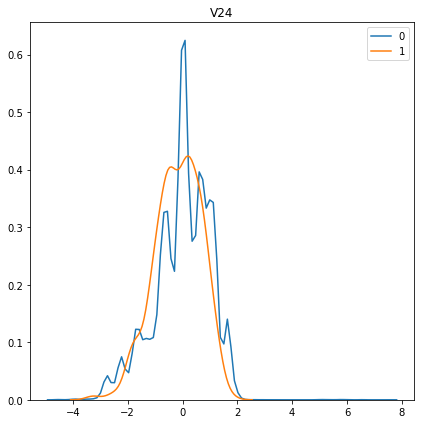

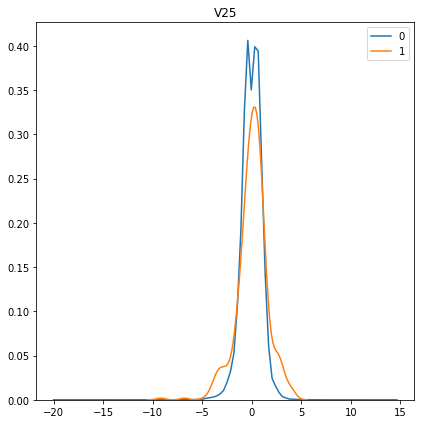

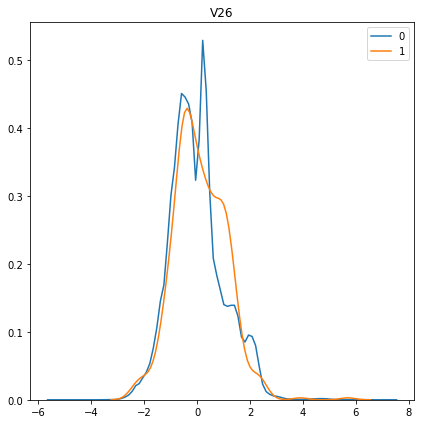

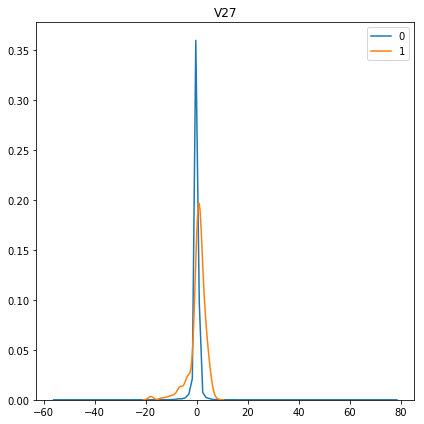

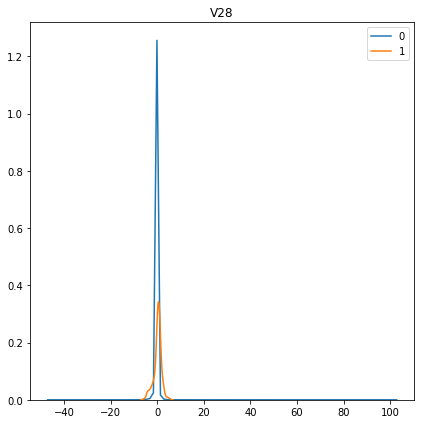

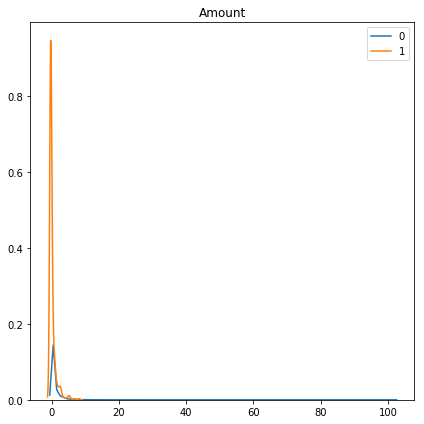

In [10]:
# Change the size of the figure
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)
# distribution of each feature w.r.t. to classes
for i, f in enumerate(features):
    sns.distplot([v[i] for v, c in zip(x, y) if c==0], hist=False, label="0")
    sns.distplot([v[i] for v, c in zip(x, y) if c==1], hist=False, label="1")
    plt.title(f)
    plt.tight_layout()
    plt.savefig("./figures/data_distribution_{}.png".format(i))
    plt.show()

# Variational AutoEncoder (VAE)

The code is inspired of this post : https://blog.keras.io/building-autoencoders-in-keras.html

You need to have graphviz installed to plot the model graph :

    sudo apt-get install graphviz

In [11]:
#  create a class VAE
class VAE:
    def __init__(self,
                 input_dim,
                 latent_dim,
                 batch_size=100,
                 epochs=9999,
                 activation="relu",
                 k_init="he_uniform",
                 optimizer="Adam",
                 alpha=0.5,
                 verbose=True):
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.k_init = k_init
        self.activation = activation
        self.latent_dim = latent_dim
        self.optimizer = optimizer
        self.alpha = alpha
        self.verbose = verbose

        x = Input(batch_shape=(self.batch_size, self.input_dim))

        encoder_h = Dense(
            self.input_dim * 2, kernel_initializer=self.k_init)(x)

        encoder_h = BatchNormalization()(encoder_h)
        encoder_h = Activation(self.activation)(encoder_h)

        encoder_h = Dense(
            int((self.input_dim * 2 + self.latent_dim) / 2),
            kernel_initializer=self.k_init)(encoder_h)

        encoder_h = BatchNormalization()(encoder_h)
        encoder_h = Activation(self.activation)(encoder_h)

        z_mean = Dense(self.latent_dim, name="latent_mean")(encoder_h)
        z_log_var = Dense(
            self.latent_dim, name="latent_log_variance")(encoder_h)

        # reparametrisation trick
        def sampling(args):
            z_mean, z_log_var = args
            # by default, random_normal has mean=0 and std=1.0
            epsilon = K.random_normal(shape=(self.batch_size, self.latent_dim))
            return z_mean + K.exp(z_log_var * 0.5) * epsilon

        # note that "output_shape" isn"t necessary with the TensorFlow backend
        z = Lambda(
            sampling, output_shape=(latent_dim, ),
            name="sampling")([z_mean, z_log_var])

        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(
            int((self.input_dim * 2 + self.latent_dim) / 2),
            kernel_initializer=self.k_init)(z)

        decoder_h = BatchNormalization()(decoder_h)
        decoder_h = Activation(self.activation)(decoder_h)

        decoder_h = Dense(
            self.input_dim * 2, kernel_initializer=self.k_init)(decoder_h)

        decoder_h = BatchNormalization()(decoder_h)
        decoder_h = Activation(self.activation)(decoder_h)

        x_decoded_mean = Dense(self.input_dim, activation="linear")(decoder_h)

        def vae_loss(x, x_decoded_mean):
            reconstruction_loss = metrics.mse(x,
                                              x_decoded_mean) * self.input_dim
            kl_loss = -0.5 * K.mean(
                1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return self.alpha * reconstruction_loss + (
                1 - self.alpha) * kl_loss

        self.autoencoder = Model(inputs=x, outputs=x_decoded_mean)
        self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)
        self.encoder = Model(inputs=x, outputs=z_mean)
        if verbose:
            self.autoencoder.summary()
            plot_model(self.autoencoder, show_shapes=True, to_file="./figures/model.png")

    def fit(self, x_train, x_valid):
        self.autoencoder.fit(
            x_train,
            x_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=1 if self.verbose else 0,
            validation_data=(x_valid, x_valid),
            callbacks=[
                callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0.01,
                    patience=5,
                    restore_best_weights=True)
            ])
        return self

    # return encoded x
    def transform(self, x):
        prediction = self.encoder.predict(x)
        return prediction.reshape((len(prediction),
                                   np.prod(prediction.shape[1:])))

    def score(self, x_train, y_train, x_test, y_test, method):
        z_train = self.encoder.predict(x_train)
        z_test = self.encoder.predict(x_test)
        method.fit(z_train, y_train)
        pred = method.predict(z_test)
        return classification_report(
            pred, y_test, output_dict=True), np.mean(pred == y_test)

# Model Analysis

In [12]:
# same input and latent size
input_dim = len(x[0])
latent_dim = 5
# create the model
vae = VAE(input_dim, latent_dim, batch_size=1000, alpha=0.5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1000, 30)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1000, 60)           1860        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (1000, 60)           240         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (1000, 60)           0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

In [13]:
# train the model
vae.fit(x_train, x_valid)

Train on 180000 samples, validate on 50000 samples
Epoch 1/9999
180000/180000 [==============================] - 9s 50us/step - loss: 18.9796 - val_loss: 14.9731
Epoch 2/9999
180000/180000 [==============================] - 2s 9us/step - loss: 13.2235 - val_loss: 13.8750
Epoch 3/9999
180000/180000 [==============================] - 2s 9us/step - loss: 12.1680 - val_loss: 11.8954
Epoch 4/9999
180000/180000 [==============================] - 2s 9us/step - loss: 11.3822 - val_loss: 11.0595
Epoch 5/9999
180000/180000 [==============================] - 2s 11us/step - loss: 10.7786 - val_loss: 10.4549
Epoch 6/9999
180000/180000 [==============================] - 1s 8us/step - loss: 10.2688 - val_loss: 10.0488
Epoch 7/9999
180000/180000 [==============================] - 2s 9us/step - loss: 9.8677 - val_loss: 9.6590
Epoch 8/9999
180000/180000 [==============================] - 1s 8us/step - loss: 9.5408 - val_loss: 9.3543
Epoch 9/9999
180000/180000 [==============================] - 2s 9us/st

180000/180000 [==============================] - 2s 9us/step - loss: 5.6851 - val_loss: 5.6868
Epoch 76/9999
180000/180000 [==============================] - 2s 9us/step - loss: 5.6811 - val_loss: 5.6892
Epoch 77/9999
180000/180000 [==============================] - 2s 9us/step - loss: 5.6583 - val_loss: 5.6605
Epoch 78/9999
180000/180000 [==============================] - 2s 9us/step - loss: 5.6400 - val_loss: 5.6430
Epoch 79/9999
180000/180000 [==============================] - 2s 10us/step - loss: 5.6323 - val_loss: 5.6584
Epoch 80/9999
180000/180000 [==============================] - 2s 8us/step - loss: 5.6179 - val_loss: 5.6211
Epoch 81/9999
180000/180000 [==============================] - 2s 8us/step - loss: 5.6043 - val_loss: 5.6243
Epoch 82/9999
180000/180000 [==============================] - 2s 9us/step - loss: 5.5923 - val_loss: 5.6248
Epoch 83/9999
180000/180000 [==============================] - 2s 9us/step - loss: 5.5750 - val_loss: 5.5667
Epoch 84/9999
180000/180000 [===

In [14]:
# project the latent representation of the validation set
z_valid = vae.transform(x_valid)

In [15]:
# split the validation set between examples of class 0 and 1
z_valid_0 = [z for i, z in enumerate(z_valid) if y_valid[i] == 0]
z_valid_1 = [z for i, z in enumerate(z_valid) if y_valid[i] == 1]

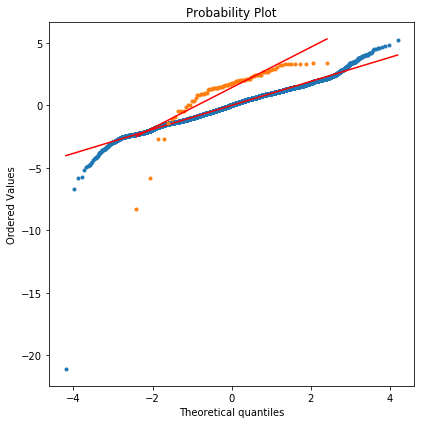

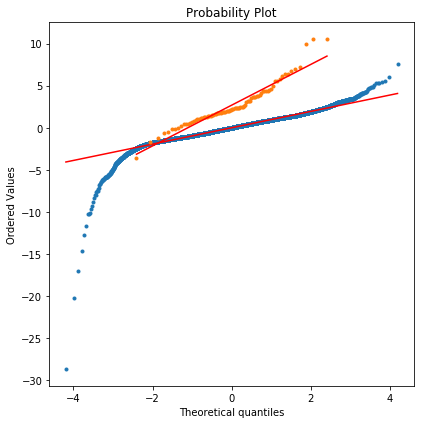

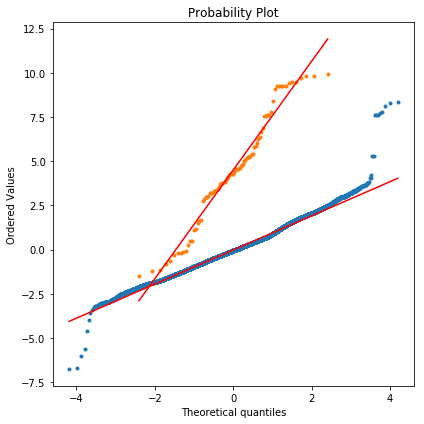

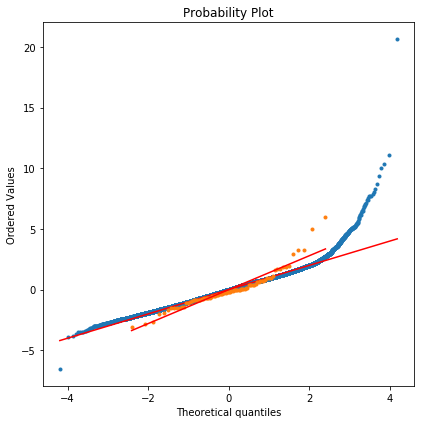

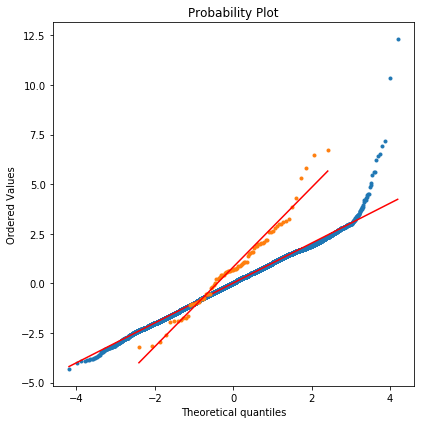

In [16]:
# Q-Q plot for each feature
for i in range(latent_dim):
    # class 1
    latent_feature = [z[i] for z in z_valid_0]
    stats.probplot(latent_feature, sparams=(0,1), plot=plt)
    # class 0
    latent_feature = [z[i] for z in z_valid_1]
    stats.probplot(latent_feature, sparams=(0,1), plot=plt)
    # change graphical style
    plt.gca().get_lines()[0].set_color('C0')
    plt.gca().get_lines()[0].set_markersize(3)
    plt.gca().get_lines()[2].set_color('C1')
    plt.gca().get_lines()[2].set_markersize(3)
    # create the legend
    plt.gca().get_lines()[0].set_label("Class 0")
    plt.gca().get_lines()[2].set_label("Class 1")
    # plot and save
    plt.tight_layout()
    plt.savefig("./figures/qq_{}.png".format(i))
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/recherche/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


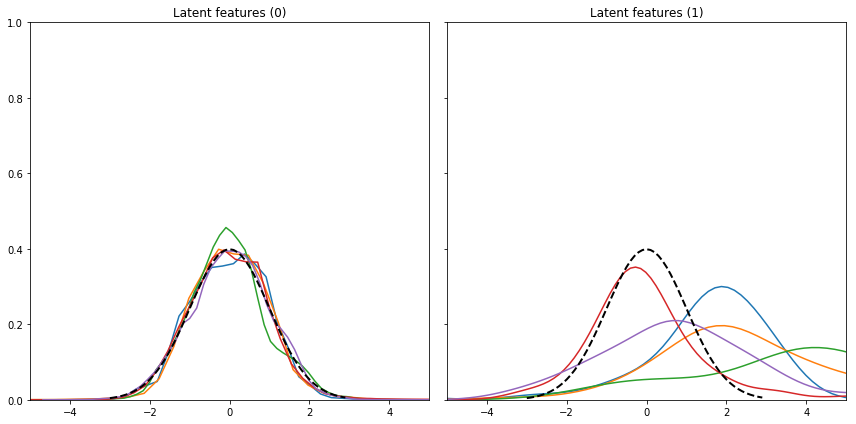

In [17]:
# Change the size of the figure
%pylab inline
pylab.rcParams["figure.figsize"] = (12, 6)
# create the figure
_, (ax1, ax2) = plt.subplots(1, 2,  sharex=True, sharey=True)
ax1.set_title("Latent features (0)")
ax2.set_title("Latent features (1)")
# print only the desired range
ax1.set_xlim((-5, 5))
ax1.set_ylim((0, 1))
# for each latent features
for i in range(latent_dim):
    latent_feature_0 = [z[i] for z in z_valid_0]
    latent_feature_1 = [z[i] for z in z_valid_1]
    # evaluate p_values for the null hypothesis: z_noise comes from a normal distribution
    sns.distplot(latent_feature_0, ax=ax1, hist=False)
    sns.distplot(latent_feature_1, ax=ax2, hist=False)
# plot density funtion of a Normal(0, 1)
h = np.arange(-3, 3, 0.1)
pdf = stats.norm.pdf(h, loc=0, scale=1)
ax1.plot(h, pdf, lw=2, ls="--", c="k")
ax2.plot(h, pdf, lw=2, ls="--", c="k")
# save and show the figure
plt.tight_layout()
plt.savefig("./figures/latent_distribution.png")
plt.show()

# Classification

In [18]:
# manual gridsearch
def gridSearch(method):
    # parameters to search on
    latent_dim = [10, 30, 50]
    alpha = [0.25, 0.5, 0.75]
    activation = ["tanh", "relu"]
    batch_size = [100, 1000]
    # noise to evaluate the normality
    noise = np.random.uniform(low=-1, high=1, size=(1000, 30))
    # header for the table
    print("({:^10s}, {:^5s}, {:^10s}, {:^10s}): {:^9s} | {:^13s} | {:^10s}".
          format("latent dim", "alpha", "activation", "batch size", "accuracy",
                 "precision (1)", "recall (1)"))
    best_accuracy, best_model = -1, None
    # grid search
    for l, a, f, b in list(
            itertools.product(latent_dim, alpha, activation, batch_size)):
        # choose the initialization accordingly to the activation function
        init = "glorot_uniform" if f == "tanh" else "he_uniform"
        # create model
        vae = VAE(
            input_dim,
            batch_size=b,
            latent_dim=l,
            alpha=a,
            activation=f,
            k_init=init,
            verbose=False)
        # train model
        vae.fit(x_train, x_valid)
        # accuracy of the method in parameter of the function gridSearch,
        # trained on the training set projection and evaluated
        # on the validation set projection
        report, accuracy = vae.score(x_train, y_train, x_valid, y_valid,
                                     method)
        # print row
        print(
            "({:^10d}, {:^5.2f}, {:^10s}, {:^10d}): {:^9.3%} | {:^12.3%} | {:^10.3%}"
            .format(l, a, f, b, accuracy, report["1"]["precision"],
                    report["1"]["recall"]))
        # save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = vae
    return vae

## LDA

In [19]:
# create default LDA model
lda = LinearDiscriminantAnalysis()
# train LDA with original (non normal) data
lda.fit(x_train, y_train)
# evaluate LDA on validaton set
pred = lda.predict(x_test)
report = classification_report(pred, y_test, output_dict=True)
print("{:^9s} | {:^14s} | {:^10s}".format("accuracy", "precision (1)",
                                          "recall (1)"))
print("{:^9.3%} | {:^14.3%} | {:^10.3%}".format(
    np.mean(pred == y_test), report["1"]["precision"], report["1"]["recall"]))

accuracy  | precision (1)  | recall (1)
 99.934%  |    77.011%     |  83.750%  


In [20]:
# Do a grid search to find the best VAE model
gridSearch(LinearDiscriminantAnalysis())

(latent dim, alpha, activation, batch size): accuracy  | precision (1) | recall (1)
(    10    , 0.25 ,    tanh   ,    100    ):  99.934%  |   77.907%    |  82.716%  
(    10    , 0.25 ,    tanh   ,    1000   ):  99.896%  |   75.581%    |  67.708%  
(    10    , 0.25 ,    relu   ,    100    ):  99.930%  |   74.419%    |  83.117%  
(    10    , 0.25 ,    relu   ,    1000   ):  99.928%  |   76.744%    |  80.488%  
(    10    , 0.50 ,    tanh   ,    100    ):  99.914%  |   79.070%    |  73.118%  
(    10    , 0.50 ,    tanh   ,    1000   ):  99.870%  |   79.070%    |  59.130%  
(    10    , 0.50 ,    relu   ,    100    ):  99.926%  |   76.744%    |  79.518%  
(    10    , 0.50 ,    relu   ,    1000   ):  99.908%  |   75.581%    |  72.222%  
(    10    , 0.75 ,    tanh   ,    100    ):  99.880%  |   76.744%    |  62.264%  
(    10    , 0.75 ,    tanh   ,    1000   ):  99.904%  |   76.744%    |  70.213%  
(    10    , 0.75 ,    relu   ,    100    ):  99.898%  |   55.814%    |  78.689%  
(  

# QDA

In [21]:
# create default LDA model
qda = QuadraticDiscriminantAnalysis()
# train LDA with original (non normal) data
qda.fit(x_train, y_train)
# evaluate LDA on validaton set
pred = qda.predict(x_test)
report = classification_report(pred, y_test, output_dict=True)
print("{:^9s} | {:^14s} | {:^10s}".format("accuracy", "precision (1)",
                                          "recall (1)"))
print("{:^9.3%} | {:^14.3%} | {:^10.3%}".format(
    np.mean(pred == y_test), report["1"]["precision"], report["1"]["recall"]))

accuracy  | precision (1)  | recall (1)
 97.426%  |    86.207%     |   5.556%  


In [22]:
# Do a grid search to find the best VAE model
gridSearch(QuadraticDiscriminantAnalysis())

(latent dim, alpha, activation, batch size): accuracy  | precision (1) | recall (1)
(    10    , 0.25 ,    tanh   ,    100    ):  99.778%  |   77.907%    |  42.138%  
(    10    , 0.25 ,    tanh   ,    1000   ):  99.616%  |   77.907%    |  27.917%  
(    10    , 0.25 ,    relu   ,    100    ):  99.678%  |   76.744%    |  31.884%  
(    10    , 0.25 ,    relu   ,    1000   ):  99.724%  |   75.581%    |  35.714%  
(    10    , 0.50 ,    tanh   ,    100    ):  99.730%  |   79.070%    |  36.757%  
(    10    , 0.50 ,    tanh   ,    1000   ):  99.502%  |   79.070%    |  22.742%  
(    10    , 0.50 ,    relu   ,    100    ):  99.706%  |   79.070%    |  34.518%  
(    10    , 0.50 ,    relu   ,    1000   ):  99.676%  |   79.070%    |  32.075%  
(    10    , 0.75 ,    tanh   ,    100    ):  99.428%  |   79.070%    |  20.238%  
(    10    , 0.75 ,    tanh   ,    1000   ):  98.806%  |   79.070%    |  10.510%  
(    10    , 0.75 ,    relu   ,    100    ):  99.414%  |   68.605%    |  18.154%  
(  

# Naive Bayes

In [23]:
# create default Naive Bayes model
naive_bayes = GaussianNB()
# train LDA with original (non normal) data
naive_bayes.fit(x_train, y_train)
# evaluate QDA on validaton set
pred = naive_bayes.predict(x_test)
report = classification_report(pred, y_test, output_dict=True)
print("{:^10s} | {:^15s} | {:^11s}".format("accuracy", "precision (1)",
                                           "recall (1)"))
print("{:^9.3%} | {:^14.3%} | {:^10.3%}".format(
    np.mean(pred == y_test), report["1"]["precision"], report["1"]["recall"]))

 accuracy  |  precision (1)  | recall (1) 
 97.818%  |    82.759%     |   6.272%  


In [24]:
# Do a grid search to find the best VAE model
gridSearch(GaussianNB())

(latent dim, alpha, activation, batch size): accuracy  | precision (1) | recall (1)
(    10    , 0.25 ,    tanh   ,    100    ):  99.786%  |   77.907%    |  43.226%  
(    10    , 0.25 ,    tanh   ,    1000   ):  99.564%  |   79.070%    |  25.373%  
(    10    , 0.25 ,    relu   ,    100    ):  99.334%  |   76.744%    |  17.414%  
(    10    , 0.25 ,    relu   ,    1000   ):  99.358%  |   66.279%    |  16.332%  
(    10    , 0.50 ,    tanh   ,    100    ):  99.740%  |   79.070%    |  37.778%  
(    10    , 0.50 ,    tanh   ,    1000   ):  99.672%  |   76.744%    |  31.429%  
(    10    , 0.50 ,    relu   ,    100    ):  99.546%  |   75.581%    |  23.985%  
(    10    , 0.50 ,    relu   ,    1000   ):  99.330%  |   79.070%    |  17.662%  
(    10    , 0.75 ,    tanh   ,    100    ):  99.716%  |   77.907%    |  35.263%  
(    10    , 0.75 ,    tanh   ,    1000   ):  99.352%  |   80.233%    |  18.351%  
(    10    , 0.75 ,    relu   ,    100    ):  99.544%  |   60.465%    |  21.138%  
(  